In [50]:
from deltas import *
from training import *
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

In [51]:
bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat > -100')

data = pd.concat([
    correct(bgu), 
    correct(bdu)
]).sort_values('reportts').drop(columns=['file_path', 'dep', 'arr'])

In [52]:
def add_egt_delta_to_dataset(dataset: pd.DataFrame, fleet=[]):
  for acnum in fleet: 
    for pos in [1, 2]:
      subset_index = (dataset['pos'] == pos) & (dataset['acnum'] == acnum)
      if dataset[subset_index].shape[0] == 0:
        continue
      subset = dataset[subset_index]
      start = subset.iloc[0]['reportts'] + pd.to_timedelta('120D')

      print(subset[subset['reportts'] < start].shape)

      baseline = train_engine_baseline(subset[subset['reportts'] < start])
      egt_delta = compute_egtm(subset, baseline)

      dataset.loc[subset_index, 'egt_delta'] = egt_delta
  return dataset

In [53]:
data = add_egt_delta_to_dataset(data, fleet)

(316, 218)
(313, 219)
(295, 219)
(417, 219)


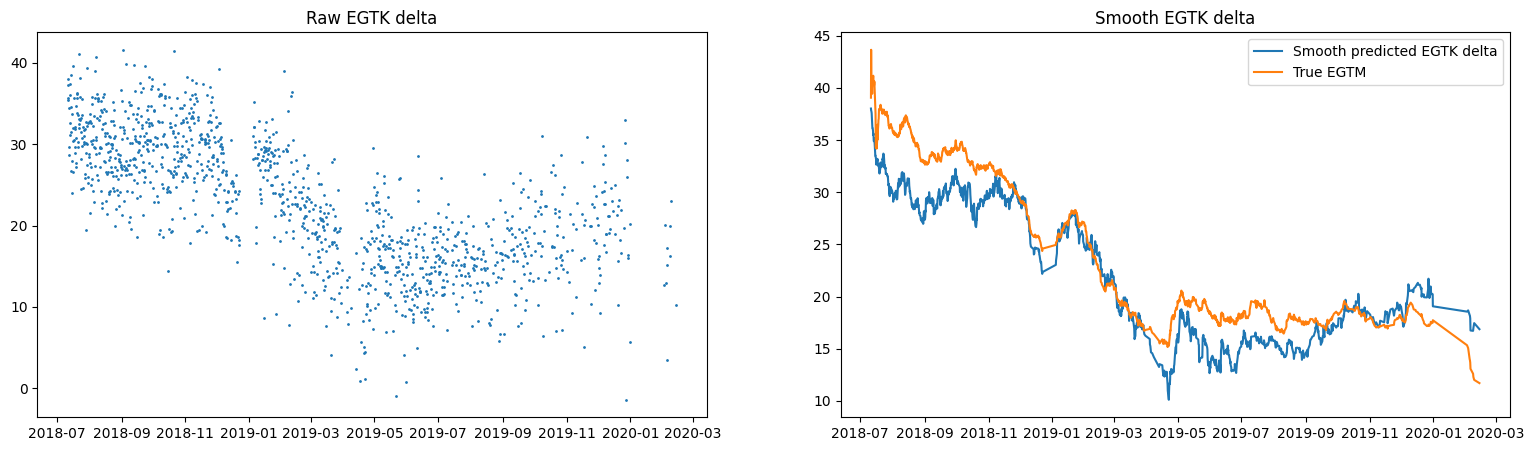

In [59]:
import matplotlib.pyplot as plt

sub = data.query('pos==2 and acnum=="VQ-BDU"')

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  sub['egt_delta'], s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(sub['egt_delta'], alpha=0.08))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()